In [1]:
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow
from joblib import Parallel, delayed

import os
import shutil
import platform

import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

mpl.rc('font', size=14)

2024-11-27 12:08:29.647295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 12:08:29.647320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 12:08:29.692710: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 12:08:29.776156: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-27 12:08:33.877873: W tensorflow/compiler/tf2

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, Dense, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import GlobalAveragePooling1D

In [3]:
def network(input_shape, ncat, learning_rate=0.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l1(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [4]:
def network_new(input_shape, ncat, learning_rate=0.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure with improvements.

    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.

    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')
    initializer = HeNormal(seed=seed)

    def conv_block(X, filters, kernel_size=5, reg=0.0032):
        # Shortcut (residual connection) path
        X_shortcut = X

        # Main path
        X = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same',
                   kernel_regularizer=l1(reg),
                   kernel_initializer=initializer)(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size=2)(X)

        # Adjust the shortcut path to match the dimensions of the main path
        X_shortcut = Conv1D(filters, kernel_size=1, padding='same')(X_shortcut)
        X_shortcut = MaxPooling1D(pool_size=2)(X_shortcut)  # Add pooling to the shortcut as well

        # Add the main path and shortcut
        X = Add()([X, X_shortcut])
        return X

    # Convolutional layers with residual connections
    X = conv_block(X_input, filters=16)
    X = conv_block(X, filters=32)
    X = conv_block(X, filters=64)
    X = conv_block(X, filters=128)

    # Flatten to fully connected dense layer.
    X = Flatten()(X)
    X = Dense(512, kernel_regularizer=l2(reg), activation='relu')(X)
    X = Dropout(rate=dropout)(X)
    X = Dense(256, kernel_regularizer=l2(reg), activation='relu')(X)
    X = Dropout(rate=dropout)(X)
    
    # Output layer with softmax activation.
    X = Dense(ncat, kernel_regularizer=l2(reg), activation='softmax', name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='Enhanced_SNnet')
    
    # Set up optimizer with learning rate scheduler
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [5]:
def network_one(input_shape, ncat, learning_rate=0.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """
    Define and compile a CNN with residual connections and enhancements.

    Parameters
    ----------
    input_shape : tuple
        Shape of the input data (e.g., (time_steps, channels)).
    ncat : int
        Number of output categories/classes.
    learning_rate : float
        Initial learning rate for the optimizer.
    reg : float
        Regularization factor for weight decay.
    dropout : float
        Dropout rate between dense layers.
    seed : int
        Seed for random number generators for reproducibility.

    Returns
    -------
    model : tensorflow.keras.Model
        Compiled Keras model ready for training.
    """

    np.random.seed(seed)
    tf.random.set_seed(seed)
    initializer = HeNormal(seed=seed)

    X_input = Input(shape=input_shape, name='Input_Spec')

    def conv_block(X, filters, kernel_size=5, pool_size=2, reg=0.0032):
        """
        Residual convolutional block with optional regularization and pooling.
        """
        X_shortcut = X

        # Main path
        X = Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same',
                   kernel_regularizer=l2(reg), kernel_initializer=initializer)(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size=pool_size)(X)

        # Shortcut path
        X_shortcut = Conv1D(filters=filters, kernel_size=1, strides=1, padding='same',
                            kernel_initializer=initializer)(X_shortcut)
        X_shortcut = MaxPooling1D(pool_size=pool_size)(X_shortcut)

        # Add the main path and the shortcut path
        X = Add()([X, X_shortcut])
        return X

    # Convolutional layers with residual connections
    X = conv_block(X_input, filters=32)
    X = conv_block(X, filters=64)
    X = conv_block(X, filters=128)
    X = conv_block(X, filters=256)

    # Global Average Pooling
    X = GlobalAveragePooling1D()(X)

    # Fully connected layers
    X = Dense(512, kernel_regularizer=l2(reg), activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(rate=dropout)(X)
    X = Dense(256, kernel_regularizer=l2(reg), activation='relu')(X)
    X = BatchNormalization()(X)
    X = Dropout(rate=dropout)(X)

    # Output layer
    X = Dense(ncat, activation='softmax', name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='Enhanced_SNnet')

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [6]:
galaxy_flux_desi = np.load("DESI_spectra/galaxy_flux.npy")
snia_flux_desi = np.load("DESI_spectra/snia_flux.npy")
snib_flux_desi = np.load("DESI_spectra/snib_flux.npy")
snibc_flux_desi = np.load("DESI_spectra/snibc_flux.npy")
snic_flux_desi = np.load("DESI_spectra/snic_flux.npy")
sniin_flux_desi = np.load("DESI_spectra/sniin_flux.npy")
sniilp_flux_desi = np.load("DESI_spectra/sniilp_flux.npy")
sniip_flux_desi = np.load("DESI_spectra/sniip_flux.npy")
kn_flux = np.load("DESI_spectra/kn_flux.npy")

In [7]:
tde_flux_ztf = np.load("ztf_spectra/tde_flux.npy")
tde_flux_paper = np.load("tde_flux_1.npy")
snia_flux_ztf = np.load("ztf_spectra/snia_flux.npy")
snii_flux_ztf = np.load("ztf_spectra/snii_flux.npy")
snib_flux_ztf = np.load("ztf_spectra/snib_flux.npy")
snic_flux_ztf = np.load("ztf_spectra/snic_flux.npy")
galaxy_flux_ztf = np.load("ztf_spectra/gal_flux.npy")
agn_flux = np.load("ztf_spectra/agn_flux.npy")
nls_flux = np.load("ztf_spectra/nls_flux.npy")
qso_flux = np.load("ztf_spectra/qso_flux.npy")

In [8]:
snia_flux = np.vstack([snia_flux_desi, snia_flux_ztf])
snibc_flux = np.vstack([snib_flux_desi, snib_flux_ztf, snibc_flux_desi, snic_flux_ztf, snic_flux_desi])
snii_flux = np.vstack([sniin_flux_desi, snii_flux_ztf, sniin_flux_desi, sniilp_flux_desi, sniip_flux_desi])
galaxy_flux = np.vstack([galaxy_flux_desi, galaxy_flux_ztf, agn_flux, nls_flux, qso_flux])
tde_flux = np.vstack([tde_flux_ztf, tde_flux_paper])

In [9]:
minw, maxw, nbins = 3000., 8000., 150

In [10]:
ngalaxy, nbins  = galaxy_flux.shape
nsnia, nbins  = snia_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnii, nbins = snii_flux.shape
ntde, nbins = tde_flux.shape
nkn, nbins = kn_flux.shape
ngalaxy, nsnia, nsnibc, nsnii, ntde, nkn, nbins

(10169, 14370, 29787, 42604, 224, 8947, 150)

In [11]:
x = np.concatenate([galaxy_flux, 
                    snia_flux,
                    snibc_flux,
                    snii_flux,
                    tde_flux,
                    kn_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Galaxy',
          'SN Ia',
          'SN Ib/c',
          'SN II',
          'TDE',
          'KN']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(ngalaxy, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnibc, 2),
                        np.full(nsnii, 3),
                        np.full(ntde, 4),
                        np.full(nkn, 5)
                       ]))

In [12]:
dropout = 0.5
model = network_new((nbins, 1), ncat=y.shape[1], dropout = dropout)
model.summary()

2024-11-27 12:08:44.638634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


Model: "Enhanced_SNnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Spec (InputLayer)     [(None, 150, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 150, 16)              96        ['Input_Spec[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 150, 16)              64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 150, 16)              0         ['batch_normaliza

In [13]:
n_sample = [ngalaxy, nsnia, nsnibc, nsnii, ntde, nkn]
weights = np.max(n_sample) / n_sample
class_weight = {}
for i in range(len(weights)):
    class_weight[i] = weights[i]
class_weight

{0: 4.189595830465139,
 1: 2.9647877522616564,
 2: 1.430288380837278,
 3: 1.0,
 4: 190.19642857142858,
 5: 4.761819604336649}

In [14]:
x.shape, y.shape

((106101, 150, 1), (106101, 6))

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 2)
len(x_test)

21221

In [16]:
print(np.sum(y_test[:,4]))
print(np.sum(y_train[:,4]))
batch = 30
epoch = 200

42.0
182.0


In [26]:
batch = 30
epoch = 210

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Monitors the validation loss
    factor=0.5,              # Reduces the learning rate by 3/4 when triggered
    patience=5,              # Waits 5 epochs with no improvement before reducing LR
    min_lr=1e-7,             # Sets the minimum learning rate to prevent it from going too low
    verbose=1                # Enables verbose mode to log the adjustments
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc = ModelCheckpoint('b{}_e{}_d5_dfilter_sntdekn.keras'.format(batch, epoch), monitor='val_loss', mode='min', verbose=1, save_best_only=True)
hist = model.fit(x_train, y_train, batch_size=batch, epochs=epoch, validation_data=(x_test, y_test), shuffle=True, verbose=True, callbacks=[es, mc, reduce_lr], class_weight=class_weight)

Epoch 1/210


2024-11-21 10:44:33.830272: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2024-11-21 10:44:35.478851: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2670f94d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-21 10:44:35.478867: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-11-21 10:44:35.488633: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732214675.586772  894014 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2830/2830 [==============================] - ETA: 0s - loss: 16.0529 - accuracy: 0.3377
Epoch 1: val_loss improved from inf to 10.66641, saving model to b30_e210_d5_dfilter_sntdekn.keras
2830/2830 [==============================] - 27s 7ms/step - loss: 16.0529 - accuracy: 0.3377 - val_loss: 10.6664 - val_accuracy: 0.4578 - lr: 2.1544e-04
Epoch 2/210
2828/2830 [============================>.] - ETA: 0s - loss: 9.9538 - accuracy: 0.5023
Epoch 2: val_loss improved from 10.66641 to 6.83168, saving model to b30_e210_d5_dfilter_sntdekn.keras
2830/2830 [==============================] - 19s 7ms/step - loss: 9.9526 - accuracy: 0.5023 - val_loss: 6.8317 - val_accuracy: 0.5943 - lr: 2.1544e-04
Epoch 3/210
2828/2830 [============================>.] - ETA: 0s - loss: 7.0812 - accuracy: 0.5705
Epoch 3: val_loss improved from 6.83168 to 5.06082, saving model to b30_e210_d5_dfilter_sntdekn.keras
2830/2830 [==============================] - 19s 7ms/step - loss: 7.0806 - accuracy: 0.5705 - val_loss: 5.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [25]:
model = tf.keras.models.load_model('b30_e180_d5_best_model_sntdekn.keras')

NameError: name 'hist' is not defined

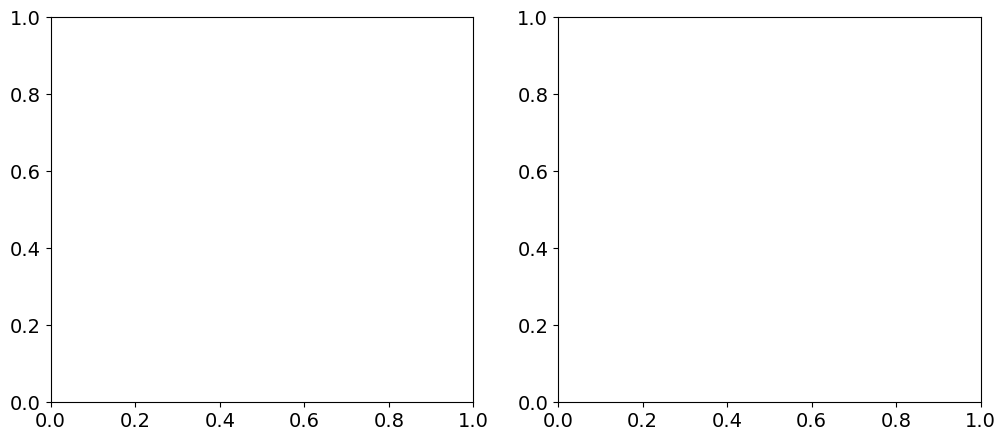

In [26]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['accuracy'], label='acc')
ax.plot(epochs, hist.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')
ax.set_yscale("log")

fig.tight_layout()
plt.savefig('b{}_e{}_accuracy.png'.format(batch, epoch))

In [27]:
tde_test = np.load("tde_flux_2.npy").reshape(-1, nbins, 1)
tde_test.shape

(27, 150, 1)

1/1 [==============================] - 0s 162ms/step


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1., 23.]),
 array([0.92631513, 0.93367743, 0.94103968, 0.94840193, 0.95576423,
        0.96312654, 0.97048879, 0.97785103, 0.98521334, 0.99257565,
        0.99993789]),
 <BarContainer object of 10 artists>)

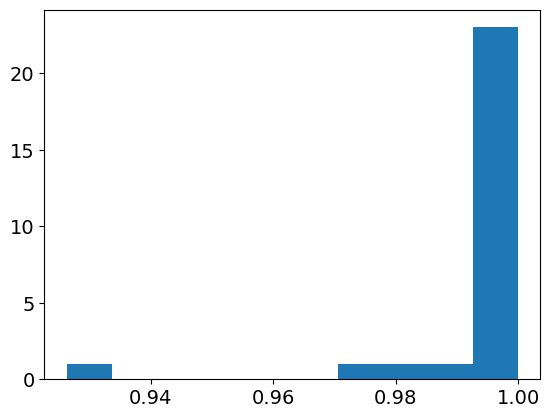

In [28]:
tde_pred = model.predict(tde_test)
plt.hist(tde_pred[:,4])

In [29]:
[labels[np.argmax(i)] for i in tde_pred]

['TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE',
 'TDE']

In [30]:
y_pred = model.predict(x_test)
y_pred

664/664 [==============================] - 1s 1ms/step


array([[5.0339215e-11, 9.9966407e-01, 3.2467139e-04, 1.1291366e-05,
        2.2687928e-15, 1.6955808e-17],
       [9.6934175e-01, 5.0036339e-03, 1.7731009e-02, 7.9129096e-03,
        3.8367298e-07, 1.0353832e-05],
       [6.5997355e-03, 2.9295844e-03, 4.6726897e-02, 9.4348156e-01,
        1.4614172e-05, 2.4766041e-04],
       ...,
       [9.5804834e-01, 1.5589421e-03, 1.6787393e-02, 2.3594091e-02,
        3.6702926e-07, 1.0868585e-05],
       [8.9261866e-01, 2.1040177e-02, 4.7514692e-02, 3.8567983e-02,
        1.5529820e-06, 2.5691593e-04],
       [2.2523038e-02, 5.2069195e-02, 2.1803787e-01, 6.4891577e-01,
        1.3181919e-04, 5.8322385e-02]], dtype=float32)

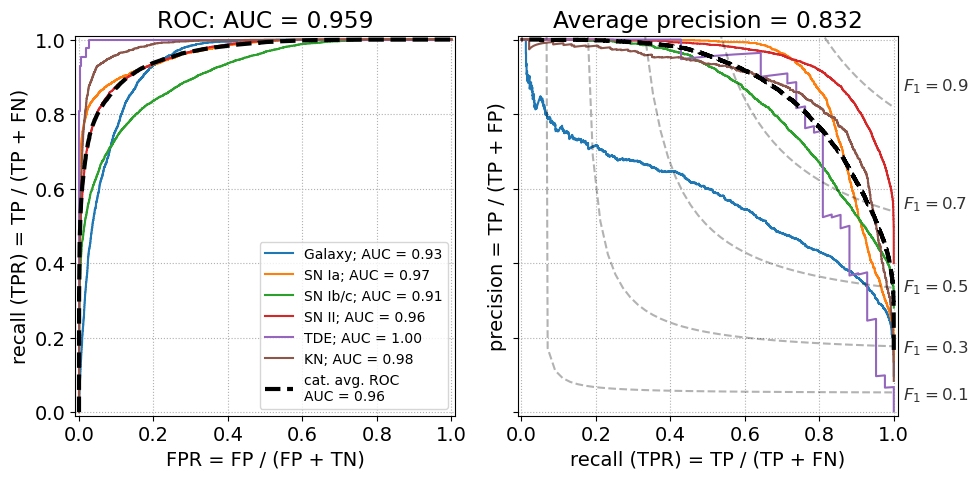

In [31]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])
    
    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')
    
    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])
    
    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])
        
ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()
plt.savefig('b{}_e{}_metrics.png'.format(batch, epoch))

In [32]:
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

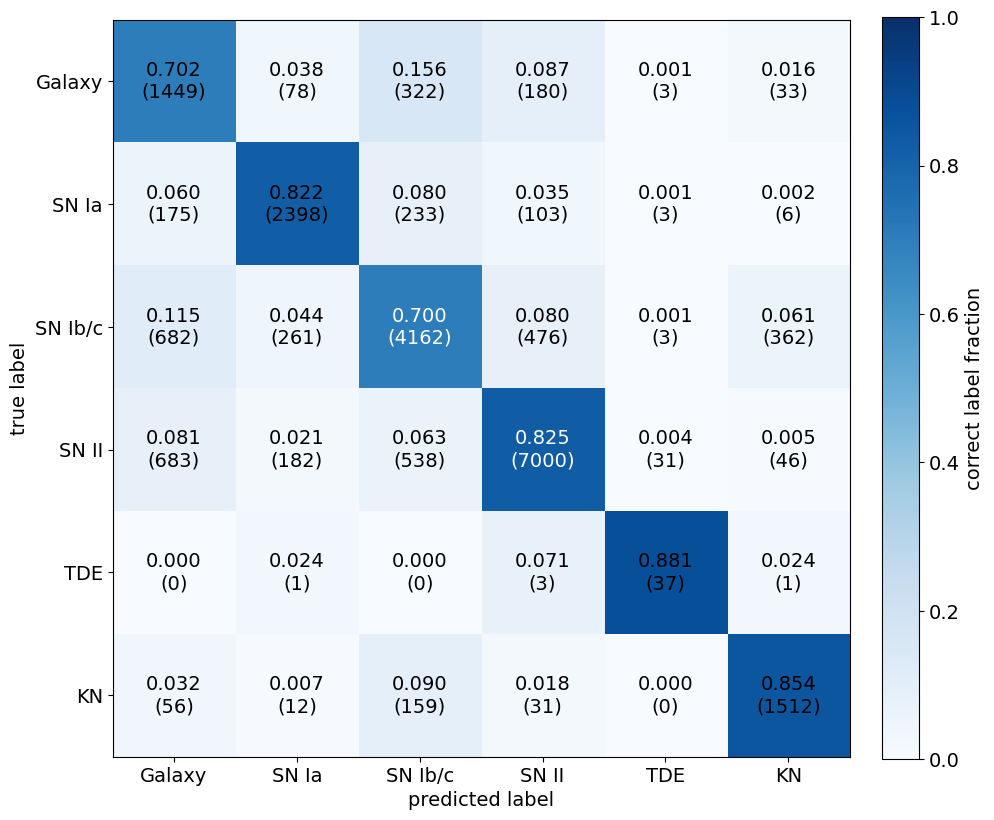

In [33]:
fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

plt.tight_layout()
plt.savefig('b{}_e{}_matrix.png'.format(batch, epoch))

In [35]:
model.summary()

Model: "Enhanced_SNnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Spec (InputLayer)     [(None, 150, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 150, 16)              96        ['Input_Spec[0][0]']          
                                                                                                  
 batch_normalization (Batch  (None, 150, 16)              64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 150, 16)              0         ['batch_normaliza